In [1]:
import sys
import torch
import matplotlib.pyplot as plt
sys.path.append('..')

device = 'cuda' if torch.cuda.is_available() else 'cpu'

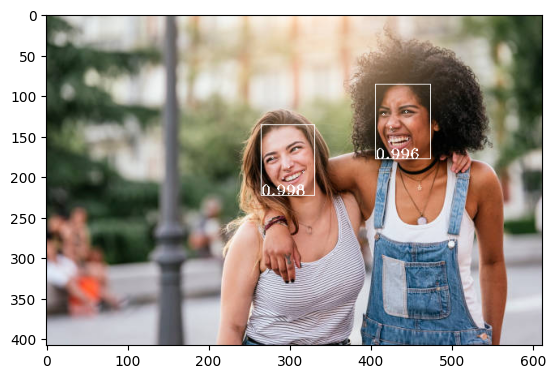

In [2]:
import facer

images = facer.hwc2bchw(facer.read_hwc('data/twogirls.jpg')
                       ).to(device=device)  # image: 1 x 3 x h x w

face_detector = facer.face_detector('retinaface/mobilenet', device=device)
with torch.inference_mode():
    faces = face_detector(images)

facer.show_bchw(facer.draw_bchw(images, faces))


In [3]:
face_parser = facer.face_parser('farl/celebm/448', device=device) # optional "farl/lapa/448"

In [4]:
with torch.inference_mode():
    faces = face_parser(images, faces)

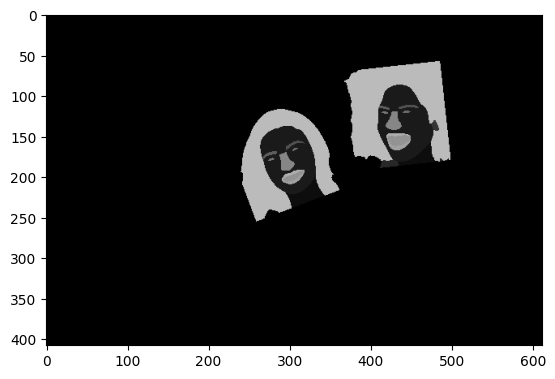

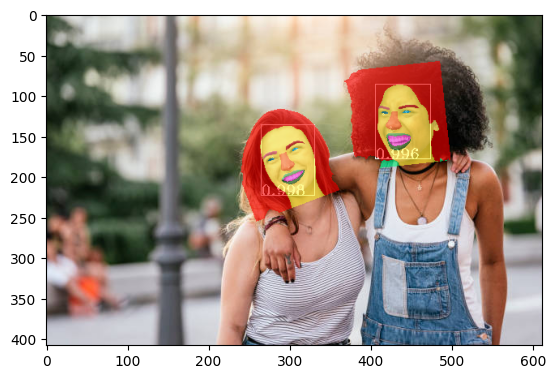

In [5]:
seg_logits = faces['seg']['logits']
seg_probs = seg_logits.softmax(dim=1)  # nfaces x nclasses x h x w
n_classes = seg_probs.size(1)
vis_seg_probs = seg_probs.argmax(dim=1).float()/n_classes*255
vis_img = vis_seg_probs.sum(0, keepdim=True)
facer.show_bhw(vis_img)
facer.show_bchw(facer.draw_bchw(images, faces))

warped_images torch.Size([2, 3, 448, 448]) min tensor(0., device='cuda:0') max tensor(0.9947, device='cuda:0')


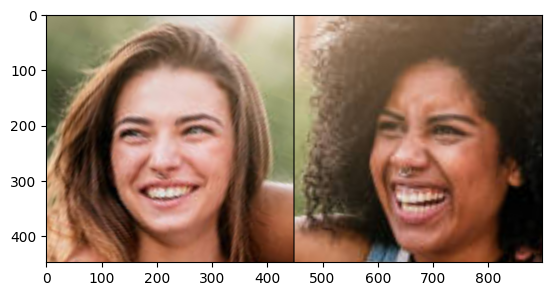

seg_logits torch.Size([2, 19, 512, 512]) min tensor(-217.1615, device='cuda:0') max tensor(73.6264, device='cuda:0')
seg_preds torch.Size([2, 512, 512]) min tensor(0, device='cuda:0') max tensor(14, device='cuda:0')


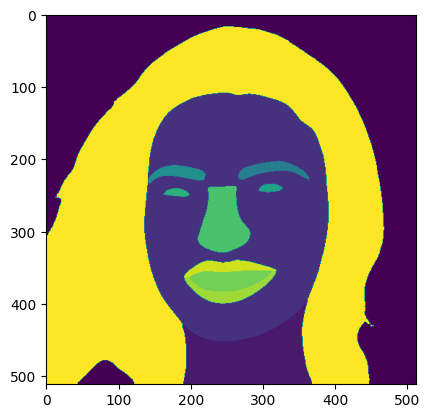

In [6]:
# manually align the image and do the network forward
with torch.inference_mode():
    faces = face_detector(images) # detect faces
warped_images, grid, inv_grid = face_parser.warp_images(images / 255.0, faces)
print('warped_images', warped_images.shape, 'min', warped_images.min(), 'max', warped_images.max())
facer.show_bchw(warped_images * 255.0)

# network forward on warped image
seg_logits, seg_preds, label_names = face_parser.forward_warped(warped_images)
print('seg_logits', seg_logits.shape, 'min', seg_logits.min(), 'max', seg_logits.max())
print('seg_preds', seg_preds.shape, 'min', seg_preds.min(), 'max', seg_preds.max())

plt.imshow(seg_preds[0].cpu().numpy())

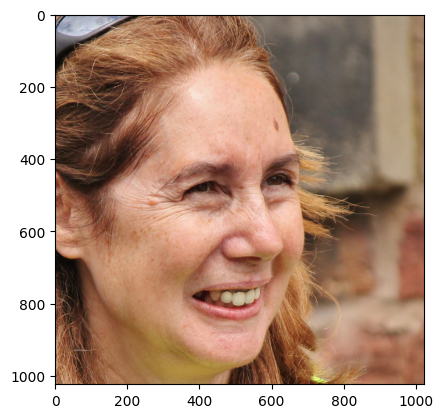

['background', 'neck', 'face', 'cloth', 'rr', 'lr', 'rb', 'lb', 're', 'le', 'nose', 'imouth', 'llip', 'ulip', 'hair', 'eyeg', 'hat', 'earr', 'neck_l']


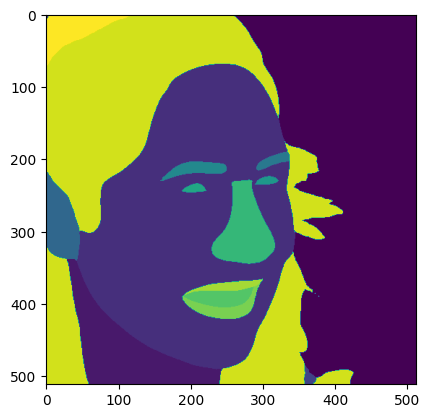

In [7]:
import torch.nn.functional as F

# on already face aligned image, for example FFHQ dataset or CelebA aligned image
images = facer.hwc2bchw(facer.read_hwc('data/ffhq_15723.jpg')).to(device=device)  # image: 1 x 3 x h x w

facer.show_bchw(images)

# do some preprocessing
images = images.to(dtype=torch.float32) / 255.0 # [0, 1]
images = F.interpolate(images, size=(448, 448), mode='bilinear', align_corners=False) # as it's already face aligned, directly resize to 448x448

seg_logits, seg_preds, label_names = face_parser.forward_warped(images)

print(label_names)

plt.imshow(seg_preds[0].cpu().numpy())